# MonteCarlo simulation of a portfolio evolution

This is an extremely simplified model of an evolution of a portfolio composed of some stocks. The covariance of the stocks is extracted at some for some time period, and then this data is used to extrapolate to the future assuming the covariance stays the same and the evolution is a brownian motion-like process.

The code is taken almost verbatim from https://www.youtube.com/watch?v=pR32aii3shk&t=16s, to whom all the rights go

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

#
def get_data(stocks,start_date,end_date):
    stockData = pdr.get_data_yahoo(stocks,start_date,end_date)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns,covMatrix


# Import data
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [31]:
#pick a bunch of stocks and a timeframe 
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)


#get the initial returns, their mean and the covariance matrix
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()


[*********************100%%**********************]  6 of 6 completed


In [32]:
# out portfolio is built out of a weighed sum of stocks
weights = np.random.rand(len(meanReturns))
weights/= sum(weights)

## Montecarlo method

In [18]:
#define the parameters of the simulation
mc_sims = 100
T = 100 #timeframe ion days

In [40]:
#get the mean in the right shape (unroll them in a tensor T * n_stocks)
meanM = np.full( shape = (T,len(weights)), fill_value = meanReturns)
meanM = meanM.T

In [43]:
#initialize the portfolio, and start with some value in dollars
portfolio_sims = np.full( shape = (T,mc_sims), fill_value = 0)
initialportfolio = 10000

In [44]:
#do the simulation 
for m in range(mc_sims):
    Z = np.random.normal(size = (T,len(weights)))
    L = np.linalg.cholesky(covMatrix)
    # compute the dayly reaturn of each stock for each of the 100 days
    daylyreturns = meanM + np.inner(L,Z)
    #this is still a mean 0 object
    #print(daylyreturns.mean(axis = 1))
    
    #take the product over days to accumulate the returns over time
    portfolio_sims[:,m] = np.cumprod(np.inner(weights,daylyreturns.T)+1)*initialportfolio

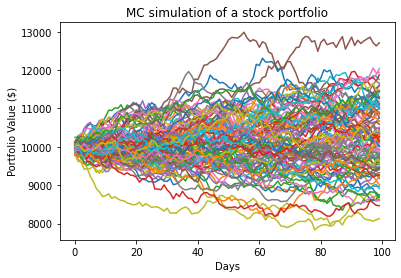

In [45]:
#plot the result
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()